Trains a Neural Network using the Data-Generator.

In [35]:
from keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from datagenerator import DataGenerator
import datetime
import pickle
from pyntcloud import PyntCloud
from mpl_toolkits.mplot3d import Axes3D

# Datasetpath.

In [2]:
if os.path.exists("datasetpath.txt"):
    dataset_path = open("datasetpath.txt", "r").read().replace("\n", "")
else:
    dataset_path = "../data"

# Instantiate the data-generator.

In [3]:
data_generator = DataGenerator(dataset_path=dataset_path, input_type="empty", output_targets=["height", "weight"])

print("jpg_paths", len(data_generator.jpg_paths))
print("pcd_paths", len(data_generator.pcd_paths))
print("json_paths_personal", len(data_generator.json_paths_personal))
print("json_paths_measures", len(data_generator.json_paths_measures))
print("QR-Codes:\n" + "\n".join(data_generator.qrcodes))

print("Done.")

jpg_paths 4511
pcd_paths 1360
json_paths_personal 40
json_paths_measures 74
QR-Codes:
SAM-02-003-01
SAM-GOV-001
SAM-GOV-002
SAM-GOV-003
SAM-GOV-004
SAM-GOV-005
SAM-GOV-008
SAM-GOV-011
SAM-GOV-012
SAM-GOV-013
SAM-GOV-014
SAM-GOV-023
SAM-GOV-025
SAM-GOV-026
SAM-GOV-033
SAM-GOV-034
SAM-GOV-035
SAM-GOV-036
SAM-GOV-037
SAM-GOV-038
SAM-GOV-041
SAM-GOV-042
SAM-GOV-043
SAM-GOV-044
SAM-GOV-099
SAM-SNG-011
SAM-SNG-012
SAM-SNG-013
SAM-SNG-014
SAM-SNG-015
SAM-SNG-016
SAM-SNG-021
SAM-SNG-036
SAM-SNG-066
SAM-SNG-067
SAM-SNG-072
SAM-SNG-091
SAM-SNG-096
Done.


#  Do the training-validation-split on QR-codes.

In [4]:
qrcodes_shuffle = list(data_generator.qrcodes)
qrcodes_shuffle = [qrcode for qrcode in qrcodes_shuffle if qrcode.startswith("SAM-GOV")]
random.shuffle(qrcodes_shuffle)
split_index = int(0.8 * len(qrcodes_shuffle))
qrcodes_train = qrcodes_shuffle[:split_index]
qrcodes_validate = qrcodes_shuffle[split_index:]

print("QR-Codes train:")
print(" ".join(qrcodes_train))
print("")

print("QR-Codes validate:")
print(" ".join(qrcodes_validate))
print("")

print("Done.")

QR-Codes train:
SAM-GOV-035 SAM-GOV-033 SAM-GOV-037 SAM-GOV-041 SAM-GOV-043 SAM-GOV-025 SAM-GOV-012 SAM-GOV-008 SAM-GOV-002 SAM-GOV-038 SAM-GOV-042 SAM-GOV-023 SAM-GOV-001 SAM-GOV-034 SAM-GOV-011 SAM-GOV-036 SAM-GOV-026 SAM-GOV-003 SAM-GOV-014

QR-Codes validate:
SAM-GOV-099 SAM-GOV-005 SAM-GOV-013 SAM-GOV-004 SAM-GOV-044

Done.


# Training.


In [ ]:
def create_model(input_shape, output_size):
    
    model = models.Sequential()

    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(output_size))
    model.summary()

    model.compile(
        optimizer="rmsprop",
        loss="mse",
        metrics=["mae"]
    )
    
    return model

# Parameters.
input_types = ["image", "pointcloud", "voxelgrid"]
input_types = ["pointcloud", "voxelgrid"]
batch_size = 32
step_per_epoch = 32
epochs = 100
validation_steps = 8

# Train the nets.
results = {}
for input_type in input_types:
    print("Training for:", input_type)
    data_generator.input_type = input_type
    
    model = create_model(data_generator.get_input_shape(), data_generator.get_output_size())

    history = model.fit_generator(
        data_generator.generate(size=batch_size, qrcodes_to_use=qrcodes_train),
        steps_per_epoch=step_per_epoch,
        epochs=epochs,
        validation_data=data_generator.generate(size=batch_size, qrcodes_to_use=qrcodes_validate),
        validation_steps=validation_steps)
    
    results[input_type] = (model, history.history)

# Can restore everything.

In [8]:
date_time_string_for_restore = None
#date_time_string_for_restore = "20180709-1445"

if date_time_string_for_restore != None:
    results = {}
    input_types_for_restore = ["image", "voxelgrid", "pointcloud"]
    for input_type in input_types_for_restore:
        model = models.load_model(date_time_string_for_restore + "-" + input_type +".h5")
        history = pickle.load(open(date_time_string_for_restore + "-" + input_type + ".p", "rb"))
        results[input_type] = (model, history)
        
    print("Loaded!")

Loaded!


# Saving models and histories.

In [ ]:
datetime_string = datetime.datetime.now().strftime("%Y%m%d-%H%M")

# Save the models and histories.    
for input_type, (model, _) in results.items():
    model_name = datetime_string + "-" + input_type
    model_path = os.path.join(model_name)
    model.save(model_path + ".h5")
    pickle.dump(history, open(model_path + ".p", "wb"))
    print("Model saved to:", model_path)
    
print("All saved.")

# Rendering histories.

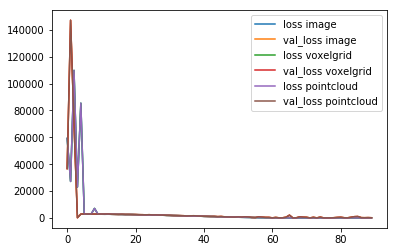

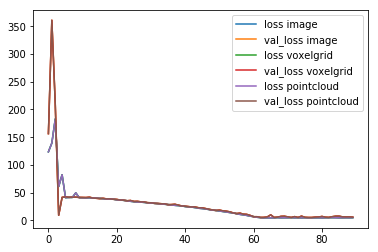

In [10]:
start_index = 10

# Loss.
for input_type, (_, history) in results.items():
    plt.plot(history["loss"][start_index:], label="loss" + " " + input_type)
    plt.plot(history["val_loss"][start_index:], label="val_loss" + " " + input_type)
plt.legend()
plt.show()
plt.close()

# Metric.
for input_type, (_, history) in results.items():
    plt.plot(history["mean_absolute_error"][start_index:], label="loss" + " " + input_type)
    plt.plot(history["val_mean_absolute_error"][start_index:], label="val_loss" + " " + input_type)
plt.legend()
plt.show()
plt.close()

# Test the model.

In [ ]:
# Evaluate.
for input_type, (model, _) in results.items():
    
    data_generator.input_type = input_type
    x_input, y_output = next(data_generator.generate(size=100, qrcodes_to_use=qrcodes_validate))
    loss, metric = model.evaluate(x_input, y_output, verbose=0)
    print("Input type:", input_type)
    print("Loss:", loss)
    print("Metric:", metric)
    print("")

voxelgrid


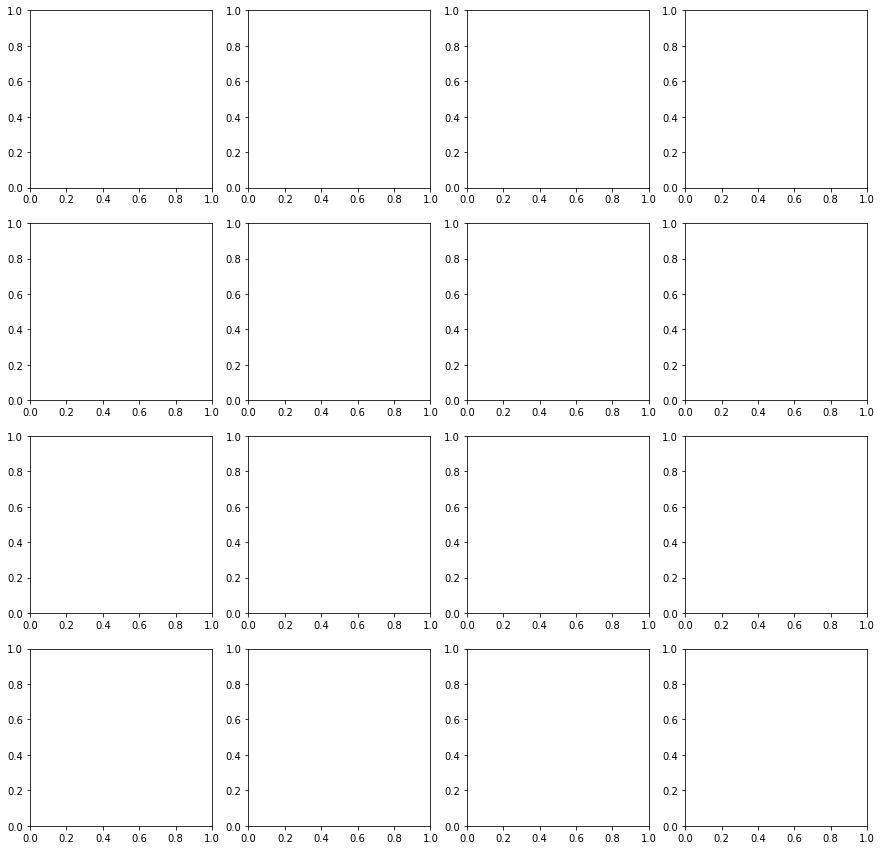

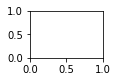

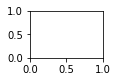

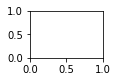

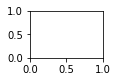

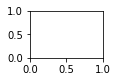

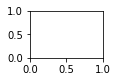

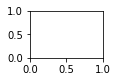

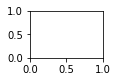

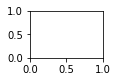

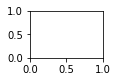

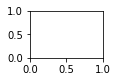

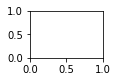

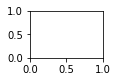

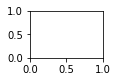

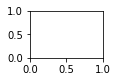

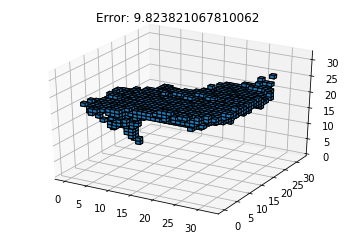

pointcloud


Exception: ('Unknown:', 'pointcloud')

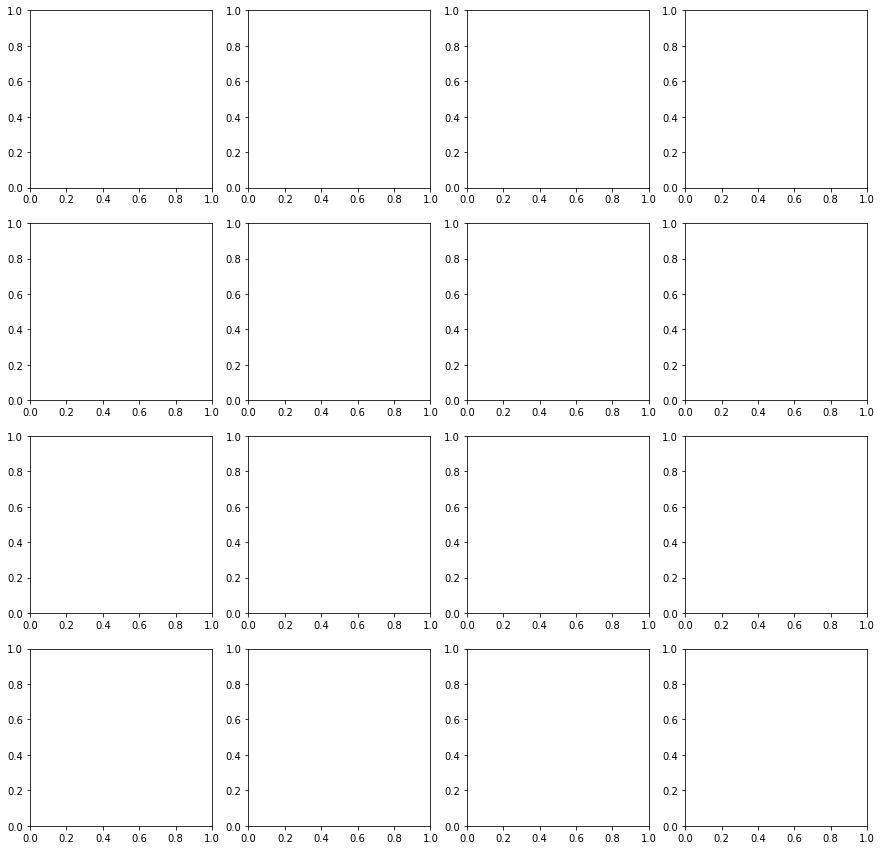

In [36]:
def render_data(data, input_type):
    
    if input_type == "image":
        plt.imshow(x_input[sorted_index])
    
    elif input_type == "voxelgrid":
        #fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.voxels(data,  edgecolor='k')
    
    else:
        raise Exception("Unknown:", input_type)
        

    
rows = 4
columns = 4
num_samples = rows * columns

# Do prediction and compare.
for input_type, (model, _) in results.items():
    
    # TODO remove this.
    if input_type == "image":
        continue
    
    print(input_type)
    
    # Create some data.
    data_generator.input_type = input_type
    x_input, y_output = next(data_generator.generate(size=num_samples, qrcodes_to_use=qrcodes_validate))
    
    # Predict.
    y_output_pred = model.predict(x_input)
    
    # Compute the errors.
    errors = np.sum(np.abs(y_output - y_output_pred), axis=1)
    
    # Sort the errors and visualize.
    sorted_indices = np.argsort(errors)
    plt.subplots(rows, columns, figsize=(15,15))
    for index, sorted_index in enumerate(sorted_indices):
        plt.subplot(rows, columns, index + 1)
        render_data(x_input[sorted_index], input_type)
        plt.title("Error: " + str(errors[sorted_index]))
    
    plt.show()
    plt.close()
 

In [ ]:
# Do prediction and compare.
for input_type, (model, _) in results.items():
    
    print(input_type)
    data_generator.input_type = input_type
    x_input, y_output = next(data_generator.generate(size=10, qrcodes_to_use=qrcodes_validate))
    y_output_pred = model.predict(x_input)

In [18]:
   
    
return
plt.title("Height " + input_type)
plt.plot(y_output[:,0], label="Truth")
plt.plot(y_output_pred[:,0], label="Predicted")
plt.plot(np.abs(y_output_pred - y_output)[:,0], label="Error")
plt.legend()
plt.savefig(datetime_string + "-" + input_type + "-height.jpg")
plt.show()
plt.close()

plt.title("Weight " + input_type)
plt.plot(y_output[:,1], label="Truth")
plt.plot(y_output_pred[:,1], label="Predicted")
plt.plot(np.abs(y_output_pred - y_output)[:,1], label="Error")
plt.legend()
plt.savefig(datetime_string + "-" + input_type + "-weight.jpg")
plt.show()
plt.close()
 
plt.title("Weight for height " + input_type)
plt.plot(y_output[:,1] / y_output[:,0], label="Truth")
plt.plot(y_output_pred[:,1] / y_output_pred[:,0], label="Predicted")
plt.legend()
plt.savefig(datetime_string + "-" + input_type + "-weight_for_height.jpg")
plt.show()
plt.close()

image
[89.3 10.8] [74.34819  8.20566] [14.95180969  2.59434013]
[64.9  7.9] [74.34819  8.20566] [9.44819031 0.30565987]
[76.5  8.4] [74.34819  8.20566] [2.15180969 0.19434013]
[89.3 10.8] [74.34819  8.20566] [14.95180969  2.59434013]
[76.2  8.3] [74.34819  8.20566] [1.85180969 0.09434013]
[63.   6.1] [74.34819  8.20566] [11.34819031  2.10565987]
[76.5  8.4] [74.34819  8.20566] [2.15180969 0.19434013]
[76.2  8.3] [74.34819  8.20566] [1.85180969 0.09434013]
[64.9  7.9] [74.34818  8.20566] [9.44818268 0.30565987]
[76.5  8.4] [74.34818  8.20566] [2.15181732 0.19434013]
voxelgrid
[64.9  7.9] [65.199265  6.530362] [0.29926453 1.36963787]
[76.5  8.4] [76.39068   8.386781] [0.10932159 0.01321926]
[89.3 10.8] [89.0289   10.547652] [0.27109985 0.25234776]
[63.   6.1] [62.943752  6.07343 ] [0.05624771 0.02656994]
[76.5  8.4] [76.7846    8.317389] [0.2845993  0.08261147]
[76.2  8.3] [64.60687   6.369644] [11.59312744  1.93035583]
[63.   6.1] [63.053272  6.110901] [0.05327225 0.01090088]
[76.2  8.3

SyntaxError: 'return' outside function (<ipython-input-18-5de56effa271>, line 12)